### **2. Disease prediction**

In [93]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
folder = "kaggle-cardio/"
cardio_file = "cardio_train.csv"

df_cardio = pd.read_csv(f"{folder}{cardio_file}", sep = ";")

In [94]:
df_cardio["bmi"] = df_cardio["weight"] / (df_cardio["height"] / 100) ** 2

In [95]:
def plot_column(df, col_name, min, max):
    return df[(df[col_name] > min) & (df[col_name] < max)]

In [96]:
df_cardio = plot_column(df_cardio, "bmi", min = 15, max = 50)

In [97]:
df_cardio["bmi_category"] = pd.cut(
    df_cardio["bmi"], 
    bins = [0, 25, 30, 35, 40, 1000], 
    labels = ["Normal", "Overweight", "Obese (Class I)", "Obese (Class II)", "Obese (Class III)"], 
    right = False
)

In [98]:
df_cardio = plot_column(df_cardio, "ap_hi", min = 75, max = 200)

In [99]:
df_cardio = plot_column(df_cardio, "ap_lo", min = 50, max = 150)

In [100]:
def ap_categorizer(hi, lo):
    '''ap_categorizer() takes blood two pressure values as arguments and returns the blood pressure category'''

    if hi >= 180 or lo >= 120: return "Hypertension crisis"
    if hi >= 140 or lo >= 90: return "Stage 2 hypertension"
    if hi < 120 and lo < 80: return "Healthy"
    if hi < 130 and lo < 80: return "Elevated"
    return "Stage 1 hypertension"

df_cardio["ap_category"] = df_cardio.apply(lambda x: ap_categorizer(x["ap_hi"], x["ap_lo"]), axis = 1).astype("category")

In [101]:
df_cardio_first = df_cardio.drop(["ap_hi", "ap_lo", "height", "weight", "bmi"], axis = 1)
df_cardio_first = pd.get_dummies(df_cardio_first, columns = ["bmi_category", "ap_category", "gender"], drop_first = True)

df_cardio_second = df_cardio.drop(["bmi_category", "ap_category", "height", "weight"], axis = 1)
df_cardio_second = pd.get_dummies(df_cardio_second, columns = ["gender"], drop_first = True)

In [102]:
df_cardio_second.head()

,id,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,gender_2
0,0,18393,110,80,1,1,0,0,1,0,21.967120,1
1,1,20228,140,90,3,1,0,0,1,1,34.927679,0
2,2,18857,130,70,3,1,0,0,0,1,23.507805,0
3,3,17623,150,100,1,1,0,0,1,1,28.710479,1
4,4,17474,100,60,1,1,0,0,0,0,23.011177,0


In [103]:

def tvt_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.5, random_state = 42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

    return X_train, X_val, X_test, y_train, y_val, y_test

datasets = {}

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_first.drop(["id", "cardio"], axis = 1), df_cardio_first["cardio"])
#datasets["first"] = {"X_train": X_train, "X_val": X_val, "X_test": X_test, "y_train": y_train, "y_val": y_val, "y_test": y_test}

X_train, X_val, X_test, y_train, y_val, y_test = tvt_split(df_cardio_second.drop(["id", "cardio"], axis = 1), df_cardio_second["cardio"])
#datasets["second"] = {"X_train": X_train, "X_val": X_val, "X_test": X_test, "y_train": y_train, "y_val": y_val, "y_test": y_test}

# To minimize risk of bugs these are deleted
#X_train, X_val, X_test, y_train, y_val, y_test

In [104]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [105]:
class EvoClassifier:
    def __init__(self, n = 100, hidden_layers = False, activation = "sigmoid", random_state = None):

        self.n = n // 2 * 2
        self.nets = []
        self.best_net = -1
        self.best_result = None
        self.validation_loss_history = []
        self.training_loss_history = []
        self.mutation_sigma = 0

        if activation == "sigmoid":
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif activation == "relu":
            self.activation_function = lambda x: np.maximum(0, x)
        elif activation == "leaky_relu":
            self.activation_function = lambda x: np.maximum(0.1 * x, x)

        self.output_activation_function = lambda x: 1 / (1 + np.exp(-x))
        
        if hidden_layers:
            self.layers = hidden_layers + [1]
        else:
            self.layers = [1]
        
        if random_state != None:
            np.random.seed(random_state)

    
    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):
        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        if validation_data:
            X_val, y_val = validation_data
        
        self.layers = [X_train.shape[1]] + self.layers

        for i in range(self.n):
            self.nets += [[]]
            for j in range(len(self.layers) - 1):
                self.nets[i] += [np.random.uniform(-3, 3, (self.layers[j], self.layers[j + 1]))]

        self.y_preds = np.zeros((len(self.nets), y_train.shape[0]))
        self.nets_loss = np.zeros(len(self.nets))
        self.sorted_indecies = np.zeros(len(self.nets))

        for epoch in range(epochs):
            for i in range(len(self.nets)):
                forward_pass = X_train.T

                for j in range(0, len(self.layers) - 2):
                    forward_pass = self.activation_function(self.nets[i][j].T @ forward_pass)

                forward_pass = self.nets[i][-1].T @ forward_pass
                forward_pass = self.output_activation_function(forward_pass)
                
                self.y_preds[i] = forward_pass.reshape(-1)
            
            self.nets_loss = np.mean(np.abs(self.y_preds - y_train), axis = 1)
            
            self.sorted_indecies = np.argsort(self.nets_loss)
            
            self.mutation_sigma = 0.1 + 5 * 1 / math.exp(epoch / (epochs / (10 * math.log10(epochs + 1))))
            
            for i in range(0, self.n // 2, 2):
                for j in range(len(self.layers) - 1):
                    self.nets[self.sorted_indecies[self.n // 2 + i]][j] = (self.nets[self.sorted_indecies[i]][j] + self.nets[self.sorted_indecies[1 + i]][j]) / 2 + np.random.normal(0, self.mutation_sigma, (self.layers[j], self.layers[j + 1]))
                    self.nets[self.sorted_indecies[self.n // 2 + 1 + i]][j] = (self.nets[self.sorted_indecies[i]][j] + self.nets[self.sorted_indecies[1 + i]][j]) / 2 + np.random.normal(0, self.mutation_sigma, (self.layers[j], self.layers[j + 1]))

            if self.best_net != self.sorted_indecies[0]:
                self.best_net = self.sorted_indecies[0]
                self.training_loss_history += [self.nets_loss[self.best_net]]

                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        forward_pass = X.T
        for j in range(0, len(self.layers) - 2):
            forward_pass = self.activation_function(self.nets[self.best_net][j].T @ forward_pass)

        forward_pass = self.output_activation_function(self.nets[self.best_net][-1].T @ forward_pass)


        return forward_pass.reshape(-1)
        

In [106]:
start, stop = 37, 38

classifier = EvoClassifier(n = 100, hidden_layers = [2], activation = "relu", random_state = 42)
#classifier.fit(datasets["second"]["X_train"][start:stop], datasets["second"]["y_train"][start:stop], epochs = 2, verbose = 1)
classifier.fit(X_train, y_train, epochs = 10, verbose = 1)

Epoch 0 - loss: 0.36403634868104445


/var/folders/xz/f2gwbn5n3vs4pz044n49z3cw0000gn/T/ipykernel_19235/1224193588.py:19: RuntimeWarning: overflow encountered in exp
  self.output_activation_function = lambda x: 1 / (1 + np.exp(-x))


Epoch 3 - loss: 0.3603206474798351
Epoch 4 - loss: 0.3346728007210599
Epoch 6 - loss: 0.3341773126205522
Epoch 7 - loss: 0.3298033393084469
Epoch 8 - loss: 0.32455883626900633
Epoch 9 - loss: 0.3191281428301951


In [244]:
y_pred = classifier.predict(X_test)
#y_pred.tolist()

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8683
           1       0.75      0.66      0.70      8382

    accuracy                           0.72     17065
   macro avg       0.73      0.72      0.72     17065
weighted avg       0.73      0.72      0.72     17065



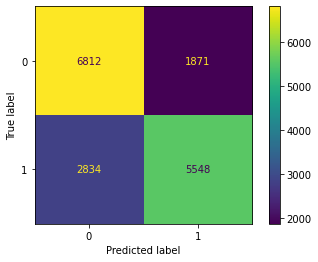

In [245]:
y_pred = (y_pred > 0.5) * 1

print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

In [109]:
import math
import numpy as np

true = [1, 0, 1, 0]
pred = [0.6, 0.2, 0.2, 0.3]

for i in range(4):
    loss = -(true[i] * math.log(pred[i]) + (1 - true[i]) * math.log(1 - pred[i]))

    print(loss)

0.5108256237659907
0.2231435513142097
1.6094379124341003
0.35667494393873245


In [110]:
y = np.array(true)
p = np.array(pred)

np.mean((y * np.log(p) + (1 - y) * np.log(1 - p))) * -1

0.6750205078632583

In [246]:
class VectorizedEvoClassifier:
    def __init__(self, n = 100, hidden_layers = False, activation = "sigmoid", random_state = None):

        self.n = n // 2 * 2
        self.best_net = -1
        self.best_result = None
        self.validation_loss_history = []
        self.training_loss_history = []
        self.mutation_sigma = 0

        if activation == "sigmoid":
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif activation == "relu":
            self.activation_function = lambda x: np.maximum(0, x)
        elif activation == "leaky_relu":
            self.activation_function = lambda x: np.maximum(0.1 * x, x)
        
        self.output_activation_function = lambda x: 1 / (1 + np.exp(-x))
        
        if hidden_layers:
            self.layers = hidden_layers + [1]
        else:
            self.layers = [1]
        
        if random_state != None:
            np.random.seed(random_state)

    
    def fit(self, X_train, y_train, epochs = 100, validation_data = False, verbose = 0):
        X_train = np.c_[np.ones(X_train.shape[0]), X_train]

        if validation_data:
            X_val, y_val = validation_data

        self.layers = [X_train.shape[1]] + self.layers

        self.y_preds = np.zeros((self.n, y_train.shape[0]))
        self.nets_loss = np.zeros(self.n)
        self.sorted_indecies = np.zeros(self.n)

        self.weights = []

        for i in range(len(self.layers) - 1):
            self.weights += [np.random.uniform(-1, 1, (self.n, self.layers[i], self.layers[i + 1]))]

        for epoch in range(epochs):
            forward_pass = X_train.T
            
            for j in range(0, len(self.layers) - 2):
                forward_pass = self.activation_function(self.weights[j].transpose(0, 2, 1) @ forward_pass)

            forward_pass = self.output_activation_function(self.weights[-1].transpose(0, 2, 1) @ forward_pass)
            
            self.y_preds = forward_pass.reshape(self.n, -1)

            self.nets_loss = np.mean(np.abs(self.y_preds - y_train), axis = 1)
            
            
            self.sorted_indecies = np.argsort(self.nets_loss)

            self.mutation_sigma = 0.1 + 5 * 1 / math.exp(epoch / ((epochs + 1) / (100 * math.log10(epochs + 1))))

            for j in range(0, len(self.layers) - 1):
                self.weights[j][self.sorted_indecies[self.n // 2::2]] = np.mean((self.weights[j][self.sorted_indecies[:self.n // 2:2]], self.weights[j][self.sorted_indecies[1:1 + self.n // 2:2]]), axis = 0) + np.random.normal(0, self.mutation_sigma, (self.n // 4, self.layers[j], self.layers[j + 1]))
                self.weights[j][self.sorted_indecies[1 + self.n // 2::2]] = np.mean((self.weights[j][self.sorted_indecies[:self.n // 2:2]], self.weights[j][self.sorted_indecies[1:1 + self.n // 2:2]]), axis = 0) + np.random.normal(0, self.mutation_sigma, (self.n // 4, self.layers[j], self.layers[j + 1]))

            if self.best_net != self.sorted_indecies[0]:
                self.best_net = self.sorted_indecies[0]
                self.training_loss_history += [self.nets_loss[self.best_net]]
                
                if validation_data:
                    self.validation_loss_history += [np.mean(np.abs(y_val - self.predict(X_val)))]
                    if verbose == 1:
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]} - val_loss: {self.validation_loss_history[-1]}")
                else:
                    if verbose == 1:
                        pass
                        print(f"Epoch {epoch} - loss: {self.training_loss_history[-1]}")


    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]

        forward_pass = X.T
        for j in range(0, len(self.layers) - 2):
            forward_pass = self.activation_function(self.weights[j][self.best_net].T @ forward_pass)

        forward_pass = self.output_activation_function(self.weights[-1][self.best_net].T @ forward_pass)
        return forward_pass.reshape(-1)


In [243]:
classifier = VectorizedEvoClassifier(n = 20, hidden_layers = [6], activation = "relu", random_state = 42)
#classifier.fit(datasets["second"]["X_train"][start:stop], datasets["second"]["y_train"][start:stop], epochs = 2, verbose = 1)
classifier.fit(X_train, y_train, epochs = 1000, verbose = 1)

Epoch 0 - loss: 0.3948271366645542
Epoch 3 - loss: 0.36741452884444964


/var/folders/xz/f2gwbn5n3vs4pz044n49z3cw0000gn/T/ipykernel_19235/903138725.py:18: RuntimeWarning: overflow encountered in exp
  self.output_activation_function = lambda x: 1 / (1 + np.exp(-x))


Epoch 5 - loss: 0.3305457191655617
Epoch 9 - loss: 0.3272249104054906
Epoch 10 - loss: 0.32680243380996044
Epoch 11 - loss: 0.32225484629538903
Epoch 14 - loss: 0.3177289365836428
Epoch 15 - loss: 0.3143183520189079
Epoch 16 - loss: 0.3122005233199692
Epoch 17 - loss: 0.31165169857038305
Epoch 18 - loss: 0.31019339813758706
Epoch 19 - loss: 0.30991456704305725
Epoch 20 - loss: 0.3087673667897483
Epoch 21 - loss: 0.3077325099580049
Epoch 23 - loss: 0.30708631080077037
Epoch 24 - loss: 0.3059606106428898
Epoch 26 - loss: 0.30590595064189424
Epoch 27 - loss: 0.30532518050476665
Epoch 28 - loss: 0.3048262493040859
Epoch 29 - loss: 0.3043844988125836
Epoch 30 - loss: 0.30303831730885833
Epoch 31 - loss: 0.30249117143238247
Epoch 32 - loss: 0.301601283268902
Epoch 34 - loss: 0.2987342371916033
Epoch 35 - loss: 0.29810107741471137
Epoch 36 - loss: 0.2968647584722182
Epoch 37 - loss: 0.29628619624486424
Epoch 39 - loss: 0.29598388790517716
Epoch 40 - loss: 0.29566831671469107
Epoch 41 - loss: 

array([0, 1])

In [224]:
np.random.seed(42)
activation_function = lambda x: 1 / (1 + np.exp(-x))


y_train2 = np.random.randint(0, 2, size = (2))

y_preds = activation_function(np.random.uniform(0, 2, size = (5, 2)))
y_preds = activation_function(np.random.uniform(0, 2, size = (5, 2)))

y_preds = np.array([[0.91758985, 0.22492438],
        [0.83053294, 0.84433992],
        [0.54817229, 0.70536465],
        [0.75789449, 0.86489857],
        [0.07120965, 0.94340209]])

y_preds, y_train2, y_preds.shape, y_train2.shape, 

(array([[0.91758985, 0.22492438],
        [0.83053294, 0.84433992],
        [0.54817229, 0.70536465],
        [0.75789449, 0.86489857],
        [0.07120965, 0.94340209]]),
 array([0, 1]),
 (5, 2),
 (2,))

In [232]:
np.mean((y_train2 * np.log(y_preds) + (1 - y_train2) * np.log(1 - y_preds)) * -1, axis = 1)

array([1.99401885, 0.97214841, 0.57174736, 0.78176235, 0.06606747])

In [233]:
activation_function(np.arange(-20, 20, 0.1))

array([2.06115362e-09, 2.27792704e-09, 2.51749871e-09, 2.78226636e-09,
       3.07487987e-09, 3.39826781e-09, 3.75566675e-09, 4.15065367e-09,
       4.58718173e-09, 5.06961984e-09, 5.60279641e-09, 6.19204764e-09,
       6.84327098e-09, 7.56298406e-09, 8.35839003e-09, 9.23744958e-09,
       1.02089606e-08, 1.12826464e-08, 1.24692526e-08, 1.37806554e-08,
       1.52299795e-08, 1.68317304e-08, 1.86019389e-08, 2.05583219e-08,
       2.27204594e-08, 2.51099909e-08, 2.77508317e-08, 3.06694120e-08,
       3.38949421e-08, 3.74597042e-08, 4.13993755e-08, 4.57533856e-08,
       5.05653109e-08, 5.58833108e-08, 6.17606095e-08, 6.82560291e-08,
       7.54345778e-08, 8.33681009e-08, 9.21359999e-08, 1.01826027e-07,
       1.12535162e-07, 1.24370587e-07, 1.37450754e-07, 1.51906574e-07,
       1.67882725e-07, 1.85539102e-07, 2.05052416e-07, 2.26617961e-07,
       2.50451575e-07, 2.76791789e-07, 3.05902227e-07, 3.38074234e-07,
       3.73629798e-07, 4.12924771e-07, 4.56352429e-07, 5.04347408e-07,
      